In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [63]:
# Loading data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [64]:
# Merging data on CustomerID
merged_data = pd.merge(transactions, customers, on='CustomerID', how='inner')

In [65]:
# Creating relevant features

# 1. Total spent per customer
customer_spend = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()

# 2. Number of transactions per customer
customer_transactions = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()

# 3. Recency: How long ago did they last purchase (difference in days from latest transaction date to now)
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
recency = merged_data.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (pd.to_datetime('today') - recency['TransactionDate']).dt.days

# 4. Average transaction value
avg_transaction_value = merged_data.groupby('CustomerID')['TotalValue'].mean().reset_index()

# 5. Frequency: How many times they have purchased
customer_frequency = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()

In [66]:
# Merge all features into one dataframe
customer_profile = customer_spend.merge(customer_transactions, on='CustomerID')
customer_profile = customer_profile.merge(recency[['CustomerID', 'Recency']], on='CustomerID')
customer_profile = customer_profile.merge(avg_transaction_value[['CustomerID', 'TotalValue']], on='CustomerID')
customer_profile = customer_profile.merge(customer_frequency[['CustomerID', 'TransactionID']], on='CustomerID')

In [67]:
# Standardizing the features (important for clustering)
scaler = StandardScaler()
customer_data = scaler.fit_transform(customer_profile[['TotalValue_x', 'TransactionID_y', 'Recency']])

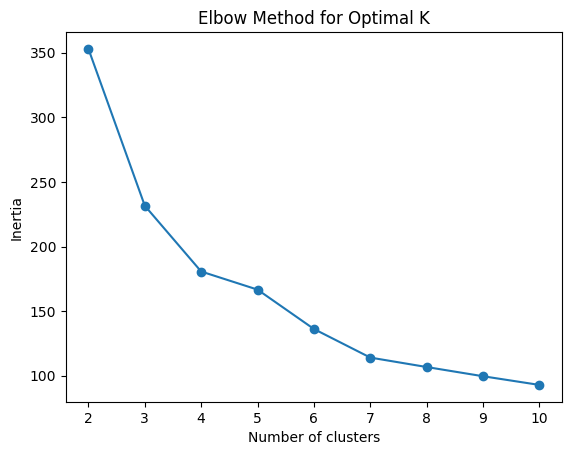

DB Index: 0.8804563786374038


In [69]:
# K-means clustering 
# Determining best number of clusters using Elbow method and DB index

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Determining the number of clusters using the elbow method
inertia = []
for k in range(2, 11):  # Testing for k between 2 and 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# From the elbow plot, optimal number of clusters is 3
optimal_k = 3

# Fit KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(customer_data)

# Calculating Davies-Bouldin Index
db_index = davies_bouldin_score(customer_data, customer_profile['Cluster'])
print("DB Index:", db_index)

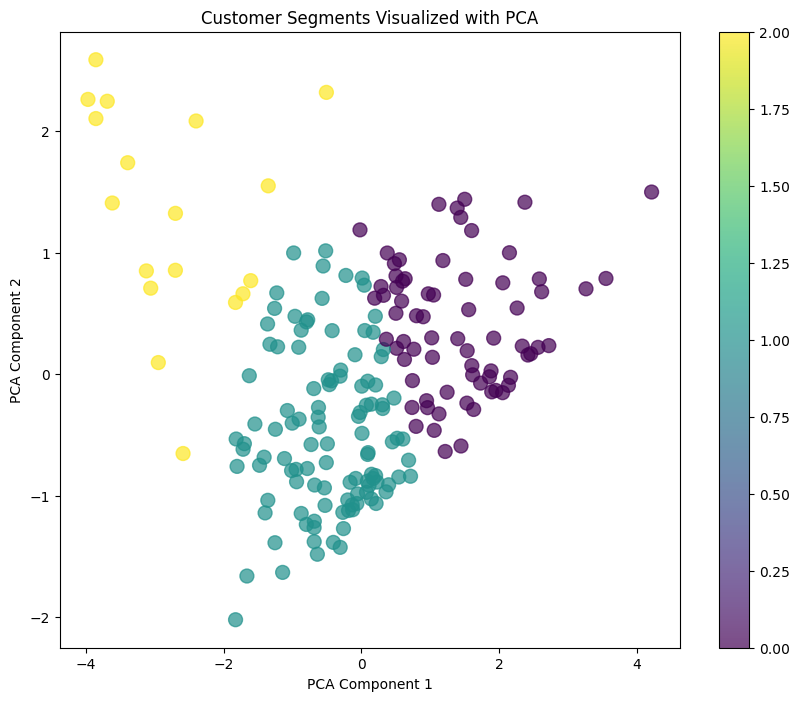

In [70]:
# Visualizing the clusters

from sklearn.decomposition import PCA

# Performing PCA to reduce data to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_data)

# Adding PCA components to the dataframe
customer_profile['PCA1'] = pca_result[:, 0]
customer_profile['PCA2'] = pca_result[:, 1]

# Ploting the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(customer_profile['PCA1'], customer_profile['PCA2'], 
                      c=customer_profile['Cluster'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter)
plt.title('Customer Segments Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [71]:
# Mapping customer ID to their corresponding cluster and similarity score
similarity_scores = pd.DataFrame(customer_data, columns=['Feature_' + str(i) for i in range(customer_data.shape[1])])
similarity_scores['Cluster'] = customer_profile['Cluster']


In [72]:
from sklearn.metrics import silhouette_score

# Computing silhouette score
sil_score = silhouette_score(customer_data, customer_profile['Cluster'])
print("Silhouette Score:", sil_score)

Silhouette Score: 0.38346587904743884
